In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.decomposition import FastICA, PCA
from sklearn.externals import joblib
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.manifold import TSNE

from time import sleep

import umap

from time import perf_counter

from utilities import drawSketch, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap, get_pca_components_for_var, plot_pca_components, df_to_heatmap, get_reconstruction_error, get_max_along_df_axis


# Define settings

In [5]:
# Import shared settings
from settings import random_state, n_jobs, test_size, pRows, pCols, pColNames, pScale, nSamples, names, accuracyMin, accuracyMax, max_iter
# Override settings
#...

In [6]:
# Set n_components to be used during grid searching (was set here based on PCA)
n_components = [1, 2, 9, 34, 98, 156, 206, 295, 478, 666, 784]

In [7]:
# Used for plot names
dim_red_name = "umap"
casename = f"quickdraw_{dim_red_name}"
# scoreText = "Score (Classification Accuracy)"

# Load and curate data

In [8]:
dataDict = getDrawData(names, nSamples=nSamples)
data = dataDict['df']
nameDict = dataDict['nameDict']

print("")
print("Loaded the following named categories, with classNumbers shown")
print(nameDict)

# Scale pixel data
for col in pColNames:
    data[col] = data[col] / pScale

Loading 2500 samples for baseball from ./data/full_numpy_bitmap_baseball.npy
Loading 2500 samples for basketball from ./data/full_numpy_bitmap_basketball.npy

Loaded the following named categories, with classNumbers shown
{'baseball': 0, 'basketball': 1}


In [9]:
# Create X, y, X_test, y_test using just the features we care about...

X_full = data.loc[:, pColNames].values
print(f'X_full.shape = {X_full.shape}')
y_full = data.loc[:, 'classNumber'].values
print(f'y_full.shape = {y_full.shape}')

X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=test_size, 
                                      random_state=random_state, stratify=y_full)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(y == 1).sum() / float(len(y))} (should be 0.5)')


print('')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
print(f'Ratio of y_test=1 to y_test=0 for Test data: {(y_test == 1).sum() / float(len(y_test))} (should be 0.5)')

X_full.shape = (5000, 784)
y_full.shape = (5000,)

X.shape = (4000, 784)
y.shape = (4000,)
Ratio of y=1 to y=0 for Training data: 0.5 (should be 0.5)

X_test.shape = (1000, 784)
y_test.shape = (1000,)
Ratio of y_test=1 to y_test=0 for Test data: 0.5 (should be 0.5)


# UMAP for visualization

n_neighbors = 5


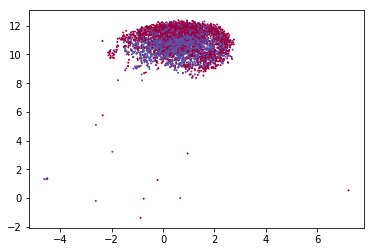

n_neighbors = 10


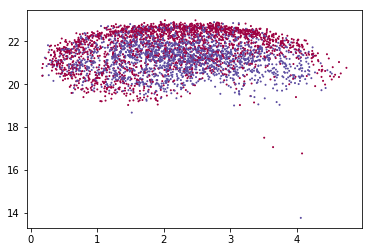

n_neighbors = 15


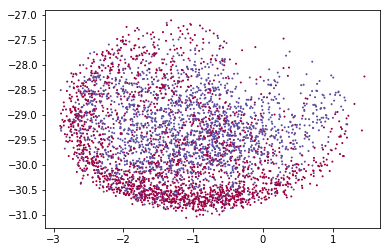

n_neighbors = 20


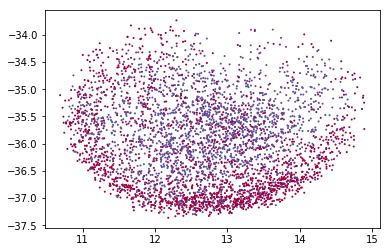

n_neighbors = 30


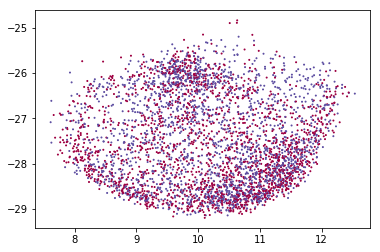

In [11]:
for n_neighbors in [5, 10, 15, 20, 30]:
    print(f"n_neighbors = {n_neighbors}")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    reducer = umap.UMAP(n_neighbors=n_neighbors)
    reducer.fit(X_scaled)

    embedding = reducer.transform(X)

    plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='Spectral', s=1)
#     plt.xlim((2, 7))
#     plt.ylim((-31, -25))
    plt.show()

# Fit using MLP through GS

In [8]:
pipe = Pipeline([('scaler', StandardScaler()),
                  ('umap', umap.UMAP(random_state=random_state)),
                  ('mlp', MLPClassifier(max_iter=max_iter, random_state=random_state))])

#                  [0.5, 0.75, 0.9, 0.95, 0.99]
hidden_layer_sizes = [(2, ), (4, ), (6, ), (10, )]
param_grid = {
             'umap__n_neighbors': [8, 15, 25],
             'umap__n_components': n_components,
             'mlp__hidden_layer_sizes': hidden_layer_sizes,
             }
gs = GridSearchCV(pipe, param_grid=param_grid, verbose=10, cv=5, return_train_score=True, 
                  n_jobs=n_jobs)

In [9]:
gs.fit(X, y)
joblib.dump(gs, casename + "_gs.pkl")

Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 48

['quickdraw_umap_gs.pkl']

In [10]:
results = pd.DataFrame(gs.cv_results_)
results.to_csv(casename + "_results.csv")

In [10]:
results = pd.read_csv(casename + "_results.csv")

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b8574264a8>)

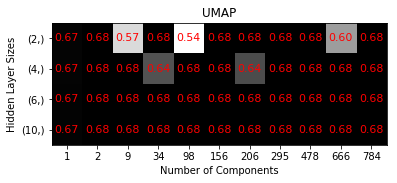

In [20]:
x_variable = "param_umap__n_components"
y_variable = "param_mlp__hidden_layer_sizes"
z_variable = "mean_test_score"

df_to_heatmap(results.loc[results.loc[:, 'param_umap__n_neighbors'] == 15], x_variable, y_variable, z_variable, fontsize=11, title=f'{dim_red_name.upper()}', xlabel='Number of Components', ylabel='Hidden Layer Sizes', savefig=f'{casename}_gs.png')